# Checkpoint 1

**Due: Tuesday, 15 October 2024 at 11:00am BST**

Total points: 100

### Read This First

* The only external Python packages you may use are `matplotlib`, `numpy`, and `scipy`.

* Use the constants provided in the cells. Do not use your own constants.

* Wherever you see `raise NotImplementedError()`, remove that line and put your code there.

* Put the code that produces the output for a given task in the cell indicated. 

* You are welcome to add as many cells as you like for imports, new function definitions, variables, etc.

* Your notebook must run correctly when executed once from start to finish. Your notebook will be graded based on how it runs, not how it looks when you submit it. To test this, go to the *Kernel* menu and select *Restart & Run All*.

* Once you are happy with it, clear the output by selecting *Restart & Clear Output* from the *Kernel* menu.

* Submit through Noteable.

* Unless specified otherwise your code for each task must complete in less than 60 seconds.


In [1]:
from matplotlib import pyplot as plt
from scipy import interpolate, sparse, integrate
from scipy.sparse import linalg as splinalg
import numpy as np
import time

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 14

![](p1.png)

In [3]:
def interpolate_files(file1, file2):
    """
    This function *must* return numpy array of interpolated values
    DO NOT MODIFY the name and arguments of the function
    But you are free to create more functions with different names.
    """
    # Reading in the data files
    x, y = np.loadtxt(file1)
    xnew = np.loadtxt(file2)
    
    # Sorting x and y in ascending order  
    ind = np.argsort(x)
    xsorted = x[ind]
    ysorted = y[ind]
    
    indnew = np.argsort(xnew)
    xnew = xnew[indnew]

    # Find the best interpolation
    ynew, best_method, best_s = find_best_interpolation(xsorted, ysorted, xnew)
    
    s_rounded = f"{best_s:.2f}" if best_s else "None"
    
    # Plotting
    plt.scatter(xsorted, ysorted, color="red", label="Original Data")
    plt.plot(xnew, ynew, color="blue", label=f"{best_method}, s = {s_rounded}")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Plot of Interpolated Values Overplotted on Original Data")
    plt.show()
    return ynew

def find_best_interpolation(xsorted, ysorted, xnew):
    
    # Generating smoothing factors to loop over to test for Univariate Spline
    smoothing_factors = np.logspace(np.log10(10), np.log10(100000), num=10000)
    best_s = None 
    
    # List of methods to test
    methods = ["UnivariateSpline", "CubicSpline", "interp1d"]

    # Intialize empty list to store MSE values
    mse_list = []
    lowest_mse_univariate = float("inf")

    # Iterating over the methods list, evaluating each method, storing the lowest MSE in a list for each method
    for method in methods:
        if method == "UnivariateSpline":
            for s in smoothing_factors:
                mse = evaluate_predictitions_spline(xsorted, ysorted, "UnivariateSpline", s)
                if mse < lowest_mse_univariate:
                    lowest_mse_univariate = mse
                    best_s_univariate = s
            mse_list.append((lowest_mse_univariate, "UnivariateSpline", best_s_univariate))
            
        elif method == "CubicSpline":
            mse = evaluate_predictitions_spline(xsorted, ysorted, method, None)
            mse_list.append((mse, "CubicSpline", None))
            
        elif method == "interp1d":
            mse = evaluate_predictitions_spline(xsorted, ysorted, method, None)
            mse_list.append((mse, "interp1d", None))
    
    # Finding the lowest MSE found in the list and corresponding method
    best_mse, best_method, best_s = min(mse_list, key=lambda x: x[0])

    # Print function for method, error, smoothing factor
    for mse, method, s in mse_list:
        s_rounded = f"{s:.2f}" if s else "None"
        print(f"MSE = {mse:.6f}, Interpolation Method = {method}, Smoothing Factor = {s_rounded}")
    
     # Perform interpolation using the best method
    if best_method == "UnivariateSpline":
        best_interpolator = interpolate.UnivariateSpline(xsorted, ysorted, s = best_s)
    elif best_method == "CubicSpline":
        best_interpolator = interpolate.CubicSpline(xsorted, ysorted)
    elif best_method == "interp1d":
        best_interpolator = interpolate.interp1d(xsorted, ysorted, kind = "linear")

    # ynew calculated based on best interpolation method
    ynew = best_interpolator(xnew)
    return ynew, best_method, best_s

def evaluate_predictitions_spline(xsorted, ysorted, method, s):
    """
    Here we test the predictive abilities of the spline
    By splitting the data into 3 chunks and returning the
    mean square deviations for a given interpolator. taken from workshop code.
    """
    nsplit = 3
    pos = np.arange(len(xsorted))
    ret = 0
    for i in range(nsplit):
        testsubset = pos % nsplit == i
        fitsubset = ~testsubset
        
        curx = xsorted[fitsubset]
        cury = ysorted[fitsubset]
        
        testx = xsorted[testsubset]
        testy = ysorted[testsubset]

        # Logic to apply different interpolation method depending on methods list
        if method == "UnivariateSpline":
            I = interpolate.UnivariateSpline(curx, cury, s=s)
        elif method == "CubicSpline":
            I = interpolate.CubicSpline(curx, cury)
        elif method == "interp1d":
            testx = np.clip(testx, curx[0], curx[-1])
            I = interpolate.interp1d(curx, cury, kind="linear")
        
        ret += np.mean((I(testx) - testy)**2)
    ret /= nsplit
    return ret

The cell below will run tests when grading.

MSE = 155.475160, Interpolation Method = UnivariateSpline, Smoothing Factor = 6922.84
MSE = 5957.452712, Interpolation Method = CubicSpline, Smoothing Factor = None
MSE = 202.199511, Interpolation Method = interp1d, Smoothing Factor = None


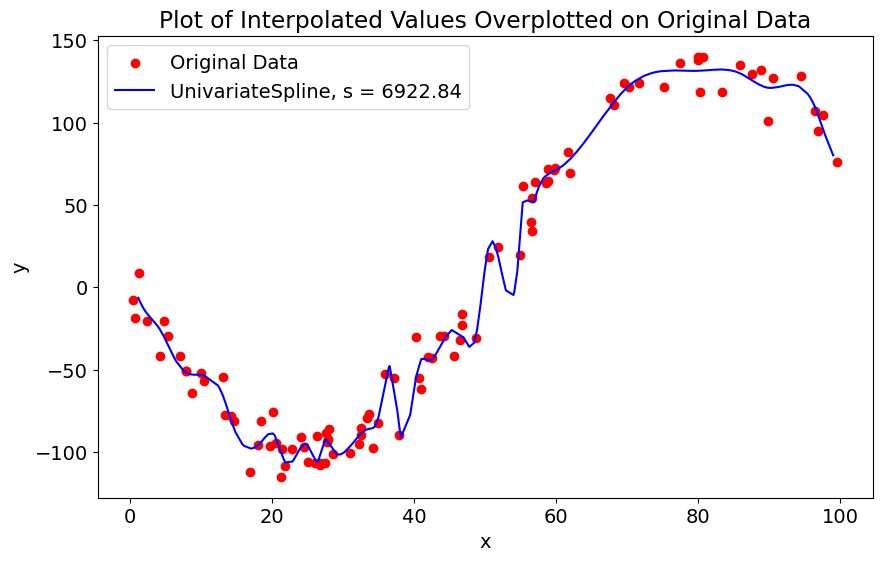

In [4]:
### print("Testing, testing...")
# This should run and return an array and do the plot
pred = interpolate_files(
    "checkpoint1_problem1_file1.txt", "checkpoint1_problem1_file2.txt"
)
# check the array of correct length is returned
assert len(pred) == 220

# Below we run additional hidden tests

![](p2.png)

In [5]:
# Constants (use these)
c1 = 0.03809982  # nm^2 eV - hbar^2/2m
c2 = 1.43996461  # nm eV - e^2/4*pi*electric_constant
r0 = 0.0529177  # nm
h = 6.62607015e-34  # J s
c = 299792458.0  # m/s
hc = 1239.8420  # eV nm

![](p2t1.png)

In [6]:
def calculate_energy_levels(tol):
    # Parameters needed for calculation
    N = 3 
    r_max = 1.5
    
    while True:
        r_min = r_max / N  #also step size (h for laplacian)
        
        r_values = np.linspace(r_min, r_max, N)

        # Kinetic energy and laplacian operator
        diagonal = -2 * np.ones(N)
        off_diagonal = np.ones(N - 1)
        T = sparse.diags([off_diagonal, diagonal, off_diagonal], [-1, 0, 1]) / r_min**2

        # Potential energy operator
        V_matrix = sparse.diags(-c2/r_values, shape = (N, N))

        # Making Hamiltonian matrix
        H = -c1 * T + V_matrix

        # Using eigsh to find eigenvalues with tolerance as an input for quicker calcualtions
        l, v = splinalg.eigsh(H, k = 2, which = "SA", tol = tol)

        # Sort and extract the two lowest energy levels
        E1, E2 = np.sort(l)[:2]

        # Theoretical energy values
        E1_theoretical = -c2 / (2 * r0)
        E2_theoretical = E1_theoretical / 4

        # Error compared to theoretical values
        error1 = abs((E1 - E1_theoretical) / E1_theoretical)
        error2 = abs((E2 - E2_theoretical) / E2_theoretical)

        # returning energy levels if they are within the tolerance
        if error1 <= tol and error2 <= tol:
            print(f"Final size of Hamiltoninan used was: {N} x {N}")
            return E1, E2

        # Increase N and try again if tolerance is not met
        N += 1  

The cell below should run your code correctly. Additional tests with other tolerance values will be used for assessment.

In [7]:
def check_p2t1(tol):
    t1 = time.time()
    E1, E2 = calculate_energy_levels(tol)
    t2 = time.time()
    print(f"Calculation time: {t2 - t1} seconds.")
    Nerror = 0

    Eth1 = -c2 / (2 * r0)
    er1 = abs((E1 - Eth1) / Eth1)
    print(f"{E1 = }, error = {er1}")
    Nerror += int(er1 > tol)

    Eth2 = Eth1 / 4
    er2 = abs((E2 - Eth2) / Eth2)
    print(f"{E2 = }, error = {er2}")
    Nerror += int(er2 > tol)
    return Nerror

my_tol = 1e-3
if check_p2t1(my_tol) == 0:
    print ("Hooray!")

Final size of Hamiltoninan used was: 448 x 448
Calculation time: 6.866612195968628 seconds.
E1 = -13.592104789066083, error = 0.0009991653942632113
E2 = -3.400572523577207, error = 0.0002505595972860291
Hooray!


![](p2t2.png)

In [8]:
def potential_numerical(r, alpha):
    
    # Function to calculate the modified force with r`
    def F_modified(r_prime):
        return -c2 * (r_prime / r0)**alpha / r_prime**2

    # Integrate from r to infinity
    V, error = integrate.quad(F_modified, r, np.inf)
    return V

The cell below will test your function for $\alpha=0.018$ for a few values of radius.

In [9]:
def potential_exact(r, alpha):
    return c2 * np.power(r, alpha - 1) * np.power(r0, -alpha) / (alpha - 1)

my_alpha = 0.018
for my_r in np.linspace(0.01, 1, 100):
    diff = abs(potential_numerical(my_r, my_alpha) - potential_exact(my_r, my_alpha))
    assert diff <= 1e-5

![](p2t3.png)

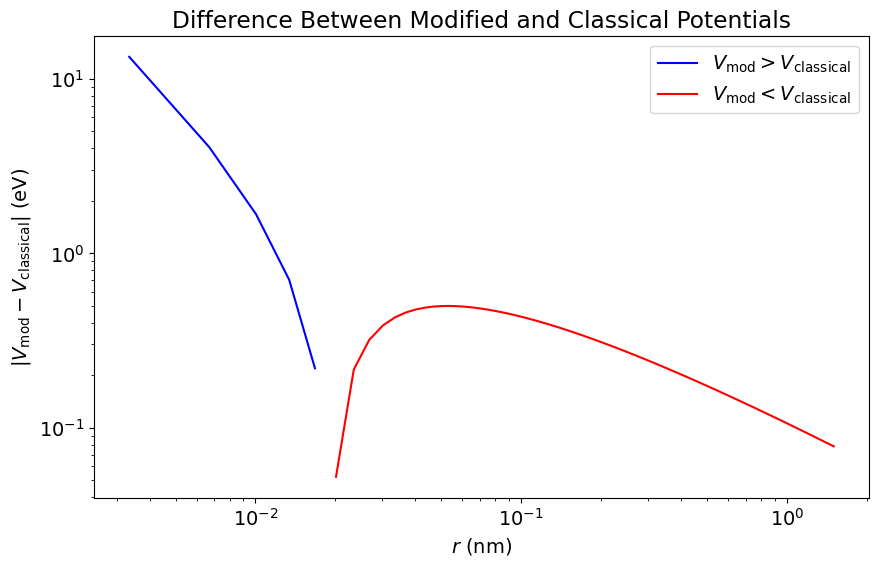

In [10]:
# Parameters needed for plotting, taken from energy tolerance function
final_N = 448 # couldn't figure out a way to use 'variable' N that updated based on task 1
r_max = 1.5 
r_min = r_max / final_N  
r_values = np.linspace(r_min, r_max, final_N)

V_classical = -c2 / r_values
V_modified = np.array([potential_numerical(r, my_alpha) for r in r_values]) # numerical or exact potential??
V_diff = V_modified - V_classical

# Separate the cases where V_mod > V_classical and V_mod < V_classical
r_greater = r_values[V_diff > 0]
V_greater = V_diff[V_diff > 0]

r_lesser = r_values[V_diff < 0]
V_lesser = -V_diff[V_diff < 0]  

# Create the plot
plt.plot(r_greater, V_greater, label = "$V_{\mathrm{mod}} > V_{\mathrm{classical}}$", color="blue") # V_mod > V_classical
plt.plot(r_lesser, V_lesser, label = "$V_{\mathrm{mod}} < V_{\mathrm{classical}}$", color="red") # V_mod < V_classical
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$r$ (nm)")
plt.ylabel("$|V_{\mathrm{mod}} - V_{\mathrm{classical}}|$ (eV)")
plt.title("Difference Between Modified and Classical Potentials")
plt.legend()
plt.show()

![](p2t4.png)

In [11]:
def calculate_energy_levels_modified(alpha):
    # Parameters needed for calculation, taken from energy tolerance function
    N = 1024 
    r_max = 1.5 
    r_min = r_max / N # also step size (h for laplacian)
    
    r_values = np.linspace(r_min, r_max, N)

    # Kinetic energy and laplacian operator
    diagonal = -2 * np.ones(N)
    off_diagonal = np.ones(N - 1)
    T = sparse.diags([off_diagonal, diagonal, off_diagonal], [-1, 0, 1]) / r_min**2

    # Modified potential energy operator (using numerical potential)
    V = np.array([potential_numerical(r, alpha) for r in r_values]) # numerical or exact potential??
    V_matrix = sparse.diags(V, shape = (N, N))

    # Making Hamiltonian matrix
    H = -c1 * T + V_matrix

    # Using eigsh to find eigenvalues with tolerance as an input for quicker calcualtions
    l, v = splinalg.eigsh(H, k=2, which = "SA", tol = 5e-4)

    # Sort and extract the two lowest energy levels
    E1, E2 = np.sort(l)[:2]
    
    return E1, E2

The cell below will test your function against various values of $\alpha$.

In [12]:
my_alpha = 0.01
E1, E2 = calculate_energy_levels_modified(my_alpha)
print(f"alpha = {my_alpha}: {E1 = }, {E2 = }")

alpha = 0.01: E1 = -13.805184248594596, E2 = -3.534497130923386


In the cell below, make the plot of $\Delta E$ vs. $\alpha$ as instructed above.

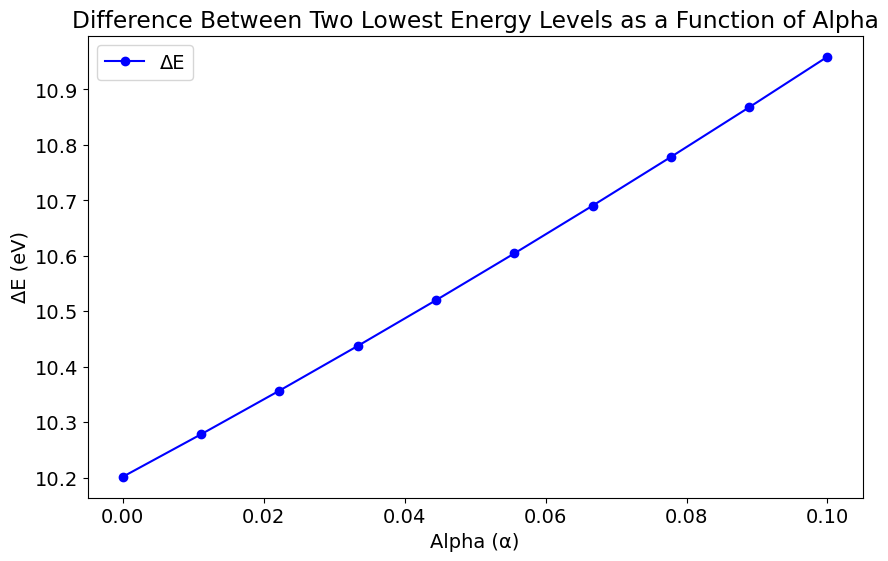

In [13]:
alpha_values = np.linspace(0, 0.1, 10)
                          
# Calculate the energy levels and the difference deltaE for each alpha
E_values = []

for alpha in alpha_values:
    E1, E2 = calculate_energy_levels_modified(alpha)
    E = abs(E2 - E1)
    E_values.append(E)
    
# Converting into an array so it can be used in the find_best_interpolation function later
E_values = np.array(E_values)

# Plot the graph
plt.plot(alpha_values, E_values, marker="o", color="b", label="ΔE" )
plt.xlabel("Alpha (α)")
plt.ylabel("ΔE (eV)")
plt.title("Difference Between Two Lowest Energy Levels as a Function of Alpha")
plt.legend()
plt.show()

![](p2t5.png)

In [14]:
def calculate_alpha(my_lambda):
    
    Enew = (hc) / my_lambda
    
    # Calling previously written interpolation method to calculate best value of alpha
    alpha, best_method, best_s = find_best_interpolation(E_values, alpha_values, Enew)

    return alpha.item()

The cell below will run your function against additional values.

In [15]:
my_lambda = 119.06389972
my_alpha = calculate_alpha(my_lambda)
print(f"{my_lambda = }, {my_alpha = }.")

MSE = 0.000000, Interpolation Method = UnivariateSpline, Smoothing Factor = 10.00
MSE = 0.000000, Interpolation Method = CubicSpline, Smoothing Factor = None
MSE = 0.000021, Interpolation Method = interp1d, Smoothing Factor = None
my_lambda = 119.06389972, my_alpha = 0.029999987274162056.


![](p3.png)

In [16]:
def calculate_ellipse_size(filename):
    
    # Read in the data
    p = np.loadtxt(filename)
    
    # Compute Covariance matrix to calculate Eigenvalues 
    cov = np.cov(p, rowvar = False)
    
    # Find Eigenvalues to find constants
    l, v = np.linalg.eigh(cov)
    
    # Order Eigenvalues to find a, b, c based on given conditions
    l = np.sort(l)[::-1]   
    
    # Square root of Eigenvalues (variance) to find standard deviation
    a, b, c = np.sqrt(l)
    return a, b, c

In [17]:
a, b, c = calculate_ellipse_size("ellipse.txt")
print(f"{a = }, {b = }, {c = }.")

a = 8.349393308146462, b = 5.061990884491184, c = 2.8558317852175312.
